In [1]:
import tensorflow as tf
import splitfolders
import numpy as np
import matplotlib.pyplot as plt

In [2]:
input_folder = "../Tomato_Disease_Classification/Dataset"

In [3]:
splitfolders.ratio(input_folder,output="../Tomato_Disease_Classification/Tomato_Dataset",seed=42,ratio=(0.8,0.1,0.1), group_prefix = None)

Copying files: 6673 files [01:11, 92.92 files/s] 


In [4]:
training_dir = "../Tomato_Disease_Classification/Tomato_Dataset/train"
validation_dir = "../Tomato_Disease_Classification/Tomato_Dataset/val"
testing_dir = "../Tomato_Disease_Classification/Tomato_Dataset/test"

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_gen_train = ImageDataGenerator(
    rescale=1/255,
    horizontal_flip=True,
    rotation_range=10
)

image_gen_valid = ImageDataGenerator(
    rescale = 1/255,
    horizontal_flip=True,
    rotation_range=10
)

image_gen_test = ImageDataGenerator(
    rescale = 1/255,
    horizontal_flip=True,
    rotation_range=10
)

In [6]:
train_data_gen  = image_gen_train.flow_from_directory(
    directory = training_dir,
    seed=40,
    batch_size=64,
    target_size=(180,180),
    class_mode = "sparse"
)

Found 5335 images belonging to 6 classes.


In [7]:
val_data_gen  = image_gen_valid.flow_from_directory(
    directory = validation_dir,
    seed=40,
    batch_size=64,
    target_size=(180,180),
    class_mode = "sparse"
)

Found 664 images belonging to 6 classes.


In [8]:
test_data_gen  = image_gen_test.flow_from_directory(
    directory=testing_dir,
    seed=40,
    batch_size=64,
    target_size=(180,180),
    class_mode = "sparse"
)

Found 673 images belonging to 6 classes.


In [9]:
num_classes = 6

In [10]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [11]:
device_name = tf.test.gpu_device_name()
print(device_name)
if device_name!='/device:GPU:0':
    raise SystemError('GPU not found')
else:
    print("GPU Found at {}".format(device_name))

/device:GPU:0
GPU Found at /device:GPU:0


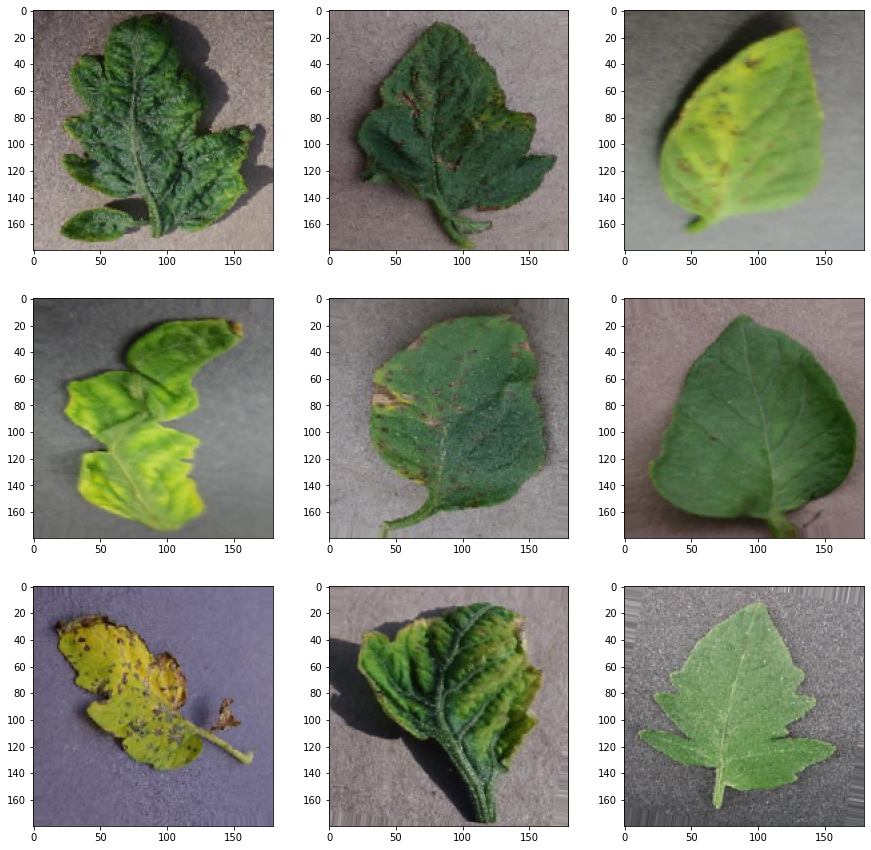

In [12]:
plt.figure(figsize=(15,15))
for i in range(9):
    #gera subfigures
    plt.subplot(330 + 1 + i)
    batch = train_data_gen.next()[0]*255
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

In [13]:
with tf.device('/gpu:0'):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32,activation=tf.nn.relu,input_shape=(180,180,3),kernel_size=(3,3),padding='same'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(32,activation=tf.nn.relu,kernel_size=(3,3),padding='same'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(32,activation=tf.nn.relu,kernel_size=(3,3),padding='same'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(32,activation=tf.nn.relu,kernel_size=(3,3),padding='same'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(32,activation=tf.nn.relu,kernel_size=(3,3),padding='same'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(32,activation=tf.nn.relu,kernel_size=(3,3),padding='same'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(64,activation=tf.nn.relu),
        tf.keras.layers.Dense(32,activation=tf.nn.relu),
        tf.keras.layers.Dense(num_classes,activation=tf.nn.softmax),
    ])

    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    training = model.fit(train_data_gen,epochs=20,batch_size=64,validation_data=val_data_gen)
    test_loss, test_acc = model.evaluate((test_data_gen))

Epoch 1/20
84/84 [==============================] - 86s 895ms/step - loss: 1.4882 - accuracy: 0.4021 - val_loss: 1.2437 - val_accuracy: 0.5151
Epoch 2/20
84/84 [==============================] - 41s 488ms/step - loss: 1.1882 - accuracy: 0.5215 - val_loss: 0.9999 - val_accuracy: 0.6145
Epoch 3/20
84/84 [==============================] - 41s 492ms/step - loss: 0.9330 - accuracy: 0.6366 - val_loss: 0.8713 - val_accuracy: 0.6551
Epoch 4/20
84/84 [==============================] - 42s 497ms/step - loss: 0.6780 - accuracy: 0.7438 - val_loss: 0.4655 - val_accuracy: 0.8404
Epoch 5/20
84/84 [==============================] - 42s 504ms/step - loss: 0.5171 - accuracy: 0.8116 - val_loss: 0.3810 - val_accuracy: 0.8645
Epoch 6/20
84/84 [==============================] - 44s 524ms/step - loss: 0.3855 - accuracy: 0.8630 - val_loss: 0.3505 - val_accuracy: 0.8645
Epoch 7/20
84/84 [==============================] - 45s 536ms/step - loss: 0.3510 - accuracy: 0.8763 - val_loss: 0.2568 - val_accuracy: 0.9111

In [14]:
class_names=list(train_data_gen.class_indices.keys())

In [15]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])] # calculate the class to whics it's belongs.
    confidence = round(100 * (np.max(predictions[0])), 2) #calculate the confidence (accuracy)
    return predicted_class, confidence

1/1 [==============================] - 0s 33ms/step


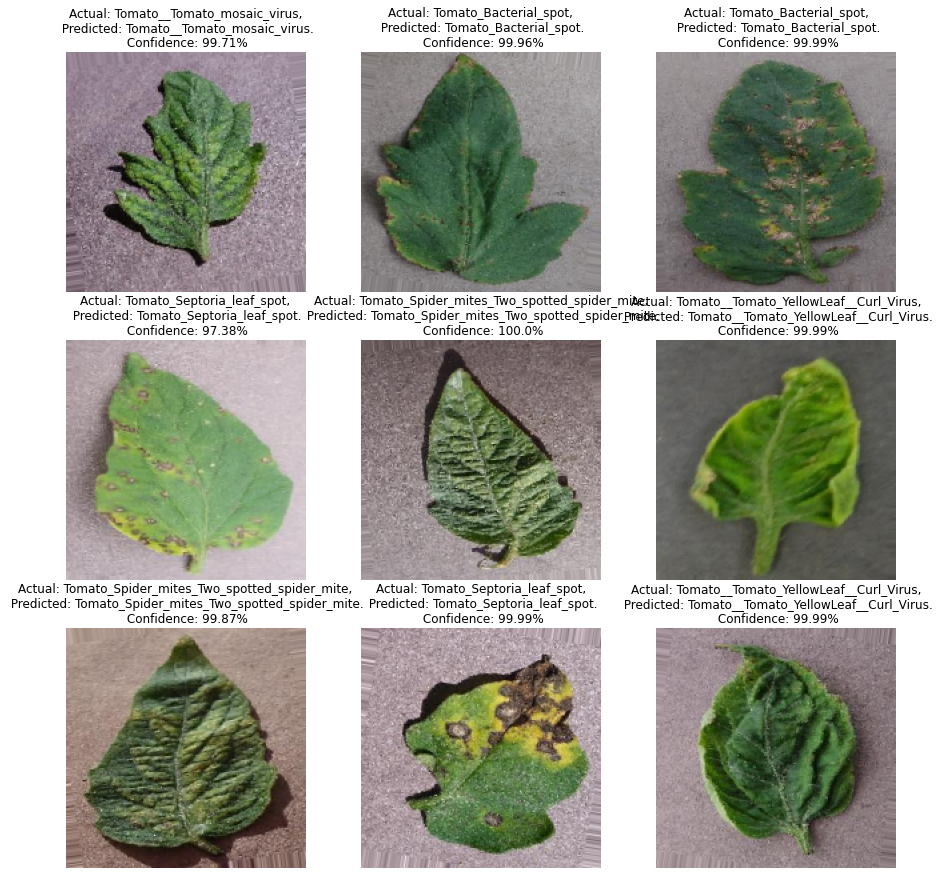

In [16]:
plt.figure(figsize=(15, 15))
for images, labels in test_data_gen:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1) #create subplots to display images with labels.
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[int(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%",color='black')
        
        plt.axis("off")
    break

In [17]:
model.save("../Tomato_Disease_Classification/tomato_disease.h5")

In [18]:
loaded_model = tf.keras.models.load_model("./tomato_disease.h5")

In [19]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 22, 22, 32)       0